<a href="https://colab.research.google.com/github/ShifaShah-06/test/blob/master/MiniThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing Public Discourse on Assisted Dying Bill**

## **Part 1: Data Scraping from Reddit**

**Data Collection**
Reddit was chosen as the primary data source due to its rich, user-generated content and active discussions on ethical and legal issues, including assisted dying. Data were collected using the Python Reddit API Wrapper (PRAW). The data collection focused on several subreddits that attract UK-based users and those interested in healthcare and politics, including: DoctorsUK, unitedkingdom, AskUK, AskReddit, ukpolitics, LibDem, and LabourUK.

**Query and Time Frame Specification**
Two search queries, “assisted dying” and “euthanasia,” were defined to capture relevant posts. In order to narrow the scope to recent discussions, only posts created between August 1, 2024, and February 1, 2025, were included. For each subreddit and query combination, the search was limited to the top 80 posts sorted by relevance.

**Rate Limiting and Data Storage**
To comply with Reddit's API usage policies and avoid rate limiting, a randomized delay (ranging from 1.5 to 3.5 seconds) was introduced between successive requests. Once data collection was complete, the aggregated data were organized into a structured format using a Pandas DataFrame. Finally, the dataset was exported as a CSV file.



In [2]:
# importing relevant libraries
import os
import praw
import pandas as pd
import time
import random
from datetime import datetime
import logging

# set the logging level for PRAW to only show errors
logging.getLogger("praw").setLevel(logging.ERROR)


# Step 1: Setup Reddit API (will remove my credentials once this block has run)
reddit = praw.Reddit(
    client_id="",
    client_secret="",
    user_agent=""
)

# Step 2: Defining paramters for data scraping
subreddits = ["DoctorsUK", "unitedkingdom", "AskUK", "AskReddit", "ukpolitics", "LibDem", "LabourUK"]
queries = ["assisted dying", "euthanasia"]
# time has been set so that the posts are captured a little before and after Assisted Dying Bill was passed in the UK
start_date = datetime(2024, 8, 1).timestamp()
end_date = datetime(2025, 2, 1).timestamp()
limit_per_subreddit = 80

# Step 3: Initialize a list to store scraped posts
all_posts = []

# Step 4: Iterate over each query and subreddit to fetch posts
for query in queries:
    for subreddit in subreddits:
        print(f"Searching r/{subreddit} for '{query}'...")
        subreddit_instance = reddit.subreddit(subreddit)

        # fetch posts based on queries
        for post in subreddit_instance.search(query, sort="relevance", time_filter="all", limit=limit_per_subreddit):

            # filter posts by date range
            if not (start_date <= post.created_utc <= end_date):
                continue

            print(f"Title: {post.title} ({post.num_comments} comments)")

            # fetch comments and remove bot and unwanted comments
            comments_text = []
            if post.num_comments > 0:
                try:
                    post.comments.replace_more(limit=0)
                    for comment in post.comments.list():
                        author_name = comment.author.name.lower() if comment.author else ""
                        comment_body = comment.body.lower()

                        if ("bot" in author_name or
                            "auto moderator" in author_name or
                            "automatically" in comment_body or
                            "[deleted]" in comment_body or
                            "[removed]" in comment_body):
                            continue

                        comments_text.append(comment.body)

                        if len(comments_text) >= 10:
                            break

                except Exception as e:
                    print(f"Error fetching comments for {post.id}: {e}")

            # Step 5: Append post details to the list
            all_posts.append({
                "ID": post.id,
                "Title": post.title,
                "URL": post.url,
                "Post_Content": post.selftext if post.selftext else "No content",
                "Comments": " || ".join(comments_text) if comments_text else "No comments",
                "Score": post.score,
                "Comments_Count": post.num_comments,
                "Created_UTC": post.created_utc
            })

        # Step 6: Randomized delay to avoid API rate limits
        time.sleep(random.uniform(1.5, 3.5))

print(f"Total posts scraped: {len(all_posts)}")

# Step 7: Save data to a csv file
if all_posts:
    df = pd.DataFrame(all_posts)

    # convert timestamps for readability
    df["Created_UTC"] = pd.to_datetime(df["Created_UTC"], unit='s')

    df.to_csv("posts_with_comments.csv", index=False)
    print("Scraping completed. Data saved to 'posts_with_comments.csv'.")
else:
    print("No data found in the given time range.")


Searching r/DoctorsUK for 'assisted dying'...
Title: Thoughts on assisted dying bill?  (91 comments)
Title: MPs vote in favour of allowing assisted dying  (188 comments)
Title: Revealed: ‘Grassroots’ campaigns opposed to assisted dying financed by conservative Christian pressure groups  (51 comments)
Title: Assisted Dying  (43 comments)
Title: Palliative care consultants & trainees. What is your opinion on the assisted dying bill currently going through parliament?  (39 comments)
Title: What are your thoughts on the vote in favour of assisted dying bill (30 comments)
Title: Withdrawal of food and water (assisted dying debate) (20 comments)
Title: Assisted dying bill has strict safeguards, MP Kim Leadbeater says (19 comments)
Title: Assisted dying bill fresh debate  (20 comments)
Title: Letter from the UK CMOs on the Assisted Dying Bill (7 comments)
Title: RCPsych debate on assisted suicide/ assisted dying (12 comments)
Title: BMA shouldn’t get involved (113 comments)
Title: We are bein

## **Part 2: Preprocessing the Scraped Data**

To prepare the Reddit dataset for subsequent natural language processing analyses—such as topic modeling, sentiment analysis, and emotion classification—a comprehensive text cleaning and normalization pipeline was developed using Python. The preprocessing pipeline was designed to remove noise inherent in social media data, thereby enhancing the quality and interpretability of the extracted features.

**Data Loading**
The raw dataset, obtained via the Reddit API, was stored as a CSV file containing both post content and associated comments. The dataset was loaded into a Pandas DataFrame, enabling efficient manipulation and application of the preprocessing steps.

The preprocessing workflow leveraged several key Python libraries and resources:

**NLTK (Natural Language Toolkit):** Utilized for tokenization, stopword removal, and lemmatization.

**Regular Expressions (regex):** Employed for removing URLs, subreddit and user mentions, markdown formatting, emojis, and non-alphabetic characters.

**Pandas:** Used for data manipulation and I/O operations.

Prior to processing, required **NLTK datasets** (e.g., stopwords, punkt_tab, and wordnet) were downloaded to support tokenization and text normalization tasks.

**Preprocessing Pipeline:**
The text cleaning process involved the following steps:

* Lowercasing
* Removal of Unwanted Elements like URLs, Emojis etc
* Tokenization
* Stopwords Removal and Token Filtering
* Lemmatization

**Reconstruction:**
The processed tokens were reassembled into a cleaned text string. This process was applied separately to both post content and comment text, generating new columns in the DataFrame (Cleaned_Post_Content and Cleaned_Comments).

In [3]:
# imporing relevant libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# uncomment to download resources (run once)
# nltk.download('stopwords')
# nltk.download('punkt_tab')
# nltk.download('wordnet')

# Step 1: Load the dataset
df = pd.read_csv("posts_with_comments.csv")

# Step 2: Initialize NLP tools
lemmatizer = WordNetLemmatizer()

# expanded stopwords list for improved filtering
custom_stopwords = set(stopwords.words('english')).union({
    'people', 'would', 'dont', 'one', 'get', 'think', 'also', 'even', 'im', 'like',
    'make', 'go', 'say', 'many', 'well', 'much', 'could', 'should', 'might', 'content'
})

# Step 3: Precompile regex patterns for efficiency
url_pattern = re.compile(r"http\S+|www\S+|https\S+")
mention_pattern = re.compile(r"(\/r\/[^\s]+)|(\/u\/[^\s]+)")
markdown_pattern = re.compile(r"[\*\_\`\~]+")
emoji_pattern = re.compile(r"[^\x00-\x7F]+")
special_chars_pattern = re.compile(r"[^a-z\s]")

# Step 4: Define the preprocessing function
def clean_text(text):
    if pd.isna(text):
        return ""

    # convert to lowercase
    text = text.lower()

    # remove URLs
    text = url_pattern.sub("", text)

    # remove subreddit and user mentions
    text = mention_pattern.sub("", text)

    # remove markdown formatting characters
    text = markdown_pattern.sub("", text)

    # remove emojis
    text = emoji_pattern.sub("", text)

    # remove special characters and numbers
    text = special_chars_pattern.sub("", text)

    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # tokenize text
    tokens = word_tokenize(text)

    # remove stopwords and perform lemmatization
    tokens = [
        lemmatizer.lemmatize(token) for token in tokens
        if token not in custom_stopwords and len(token) > 2
    ]

    return " ".join(tokens)

# Step 5: Apply preprocessing to content and comments
df["Cleaned_Post_Content"] = df["Post_Content"].apply(clean_text)
df["Cleaned_Comments"] = df["Comments"].apply(clean_text)

# Step 6: Save the cleaned data
df.to_csv("cleaned_data.csv", index=False)
print("NLP preprocessing completed! Cleaned data saved to 'cleaned_data.csv'.")


NLP preprocessing completed! Cleaned data saved to 'cleaned_data.csv'.


## **Part 3: NLP Analysis**

The cleaned dataset was read into a Pandas DataFrame from cleaned_data.csv. Necessary Python libraries—such as NLTK for sentiment analysis, scikit-learn for topic modeling, and matplotlib for visualization—were imported to facilitate text analytics tasks.

**Sentiment Analysis Setup:**
NLTK's VADER (Valence Aware Dictionary and sEntiment Reasoner) was initialized by downloading the vader_lexicon. To capture both post and comment context, a combined text field (Combined_Text) was created by concatenating the cleaned post content and comment text.

A custom function (compute_sentiment) applied VADER’s compound score to the combined text. Texts with scores ≥ 0.1 were labeled “positive,” those ≤ −0.1 were labeled “negative,” and the remainder were labeled “neutral.” This classification provides an overview of emotional tone within each piece of text.

**Text Cleaning for Visualization**
Before generating a word cloud, repeated words in the Combined_Text field were reduced by a regex-based function. This step helps avoid artificially large word counts from duplicate words in sequence.

**Word Cloud Generation**
A word cloud was created from the combined text using the WordCloud library. This visualization highlights the most frequent terms in a single image, offering a quick overview of prevalent themes in the discussions.

**Word Frequency Histogram**
All tokens were split, and their frequencies were counted using Python’s Counter. The top 20 most frequent words were displayed in a bar chart, providing a more quantitative view of key vocabulary.

**Topic Modeling with Latent Dirichlet Allocation (LDA)**
To explore underlying thematic structures, a CountVectorizer (with a maximum of 1000 features and English stopwords removed) was applied to the combined text. The resulting document-term matrix was fed into an LDA model set to extract 5 topics. Top words for each topic were printed, and the most probable topic was assigned to each document.

In [12]:
# !pip install --upgrade numpy
# !pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 83.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found e

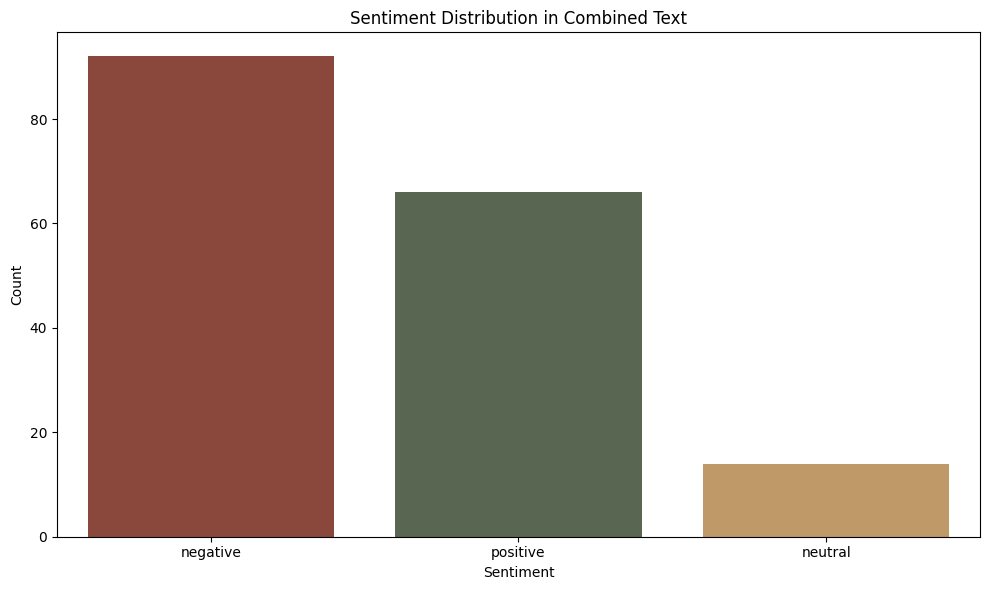

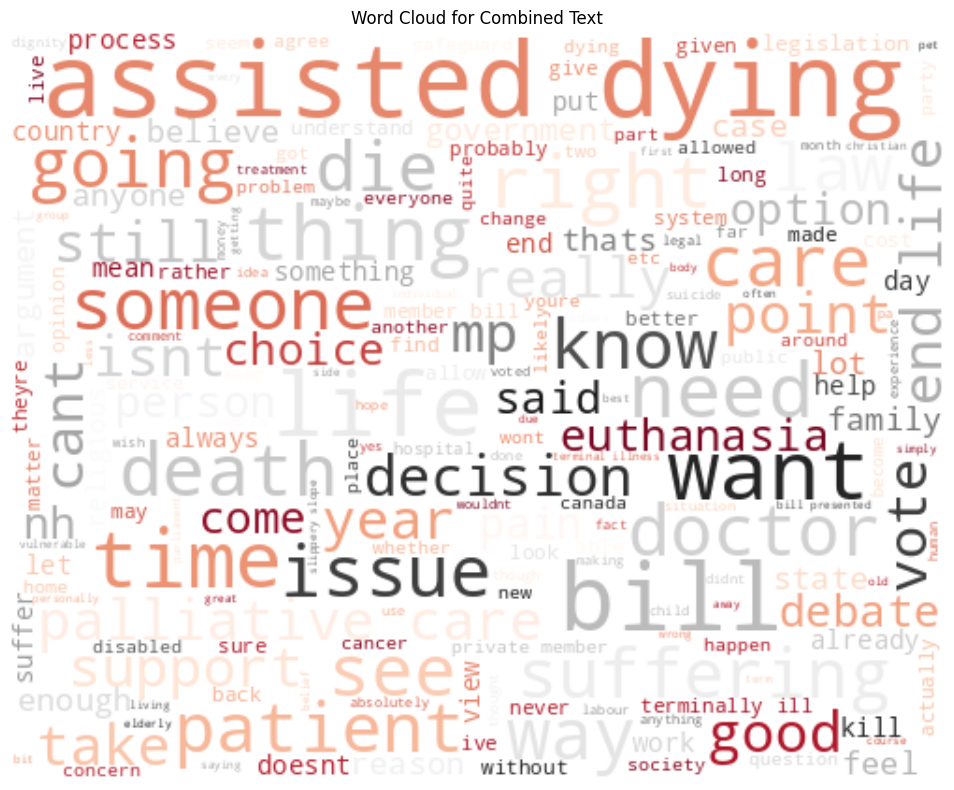

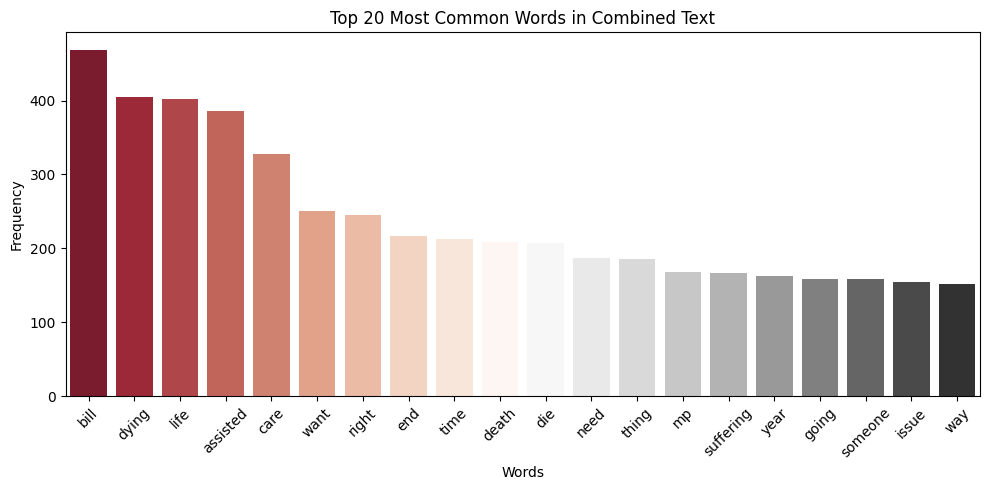

LDA Topics:
Topic 1: life, dying, assisted, care, want, die, death, end, right, suffering
Topic 2: private, member, reading, presented, published, government, requires, england, applies, pay
Topic 3: labour, england, right, time, secretary, progressive, year, scottish, old, comment
Topic 4: mp, vote, dying, assisted, care, life, voted, issue, said, legislation
Topic 5: assisted, care, dying, opinion, thing, doctor, argument, patient, need, service
Comprehensive NLP analysis completed. Data saved to 'reddit_final_analysis.csv'.


In [8]:
# importing relevant libraries
import pandas as pd
import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
from itertools import combinations

# Step 1: Load preprocessed data
df = pd.read_csv("cleaned_data.csv")

# Step 2: Convert 'Created_UTC' to datetime.
df["Created_UTC"] = pd.to_datetime(df["Created_UTC"], errors='coerce')
df.dropna(subset=["Created_UTC"], inplace=True)
df["Date"] = df["Created_UTC"].dt.date

# Step 3: Download the VADER lexicon
nltk.download('vader_lexicon', quiet=True)
analyzer = SentimentIntensityAnalyzer()

# Step 4: Combine the post content and comments for comprehensive analysis
df["Combined_Text"] = df["Cleaned_Post_Content"].fillna("") + " " + df["Cleaned_Comments"].fillna("")

# Step 5: Define sentiment computation with custom thresholds
def compute_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return "neutral"
    score = analyzer.polarity_scores(text)['compound']
    return "positive" if score >= 0.1 else "negative" if score <= -0.1 else "neutral"

# Step 6: Apply sentiment analysis on the combined text
df["Combined_Sentiment"] = df["Combined_Text"].apply(compute_sentiment)

# visualize sentiment distribution
custom_palette = {
    "positive": "#56694F", "neutral": "#CD9B59", "negative": "#963F2E"
    }

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Combined_Sentiment", hue="Combined_Sentiment", dodge=False, palette=custom_palette)
plt.title("Sentiment Distribution in Combined Text")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Step 7: Function to remove repeated words (to help with word cloud clarity)
def remove_repeated_words(text):
    return re.sub(r'(?i)\b(\w+)\b(?:\s+\1\b)+', r'\1', text)

df["Combined_Text"] = df["Combined_Text"].apply(remove_repeated_words)

# Step 8: Generate a Word Cloud
wordcloud_text = " ".join(df["Combined_Text"].dropna())
wordcloud = WordCloud(width=500, height=400, background_color="white", colormap="RdGy").generate(wordcloud_text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Combined Text")
plt.tight_layout()
plt.show()

# Step 9: Create a word frequency histogram
all_words = " ".join(df["Combined_Text"].dropna()).split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(counts), palette="RdGy")
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words in Combined Text")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Step 10: Topic Modelling with LDA
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
dtm_combined = vectorizer.fit_transform(df["Combined_Text"].fillna(""))

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm_combined)

print("LDA Topics:")
for idx, topic in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {idx + 1}: {', '.join(top_words)}")

# assign a topic label to each document (highest probability topic)
df["Topic"] = lda.transform(dtm_combined).argmax(axis=1)

# # Step 11: Advanced Topic Modelling with BERTopic
# try:
#     from bertopic import BERTopic
#     bertopic_model = BERTopic()
#     bertopic_topics, _ = bertopic_model.fit_transform(df["Combined_Text"].fillna(""))
#     df["BERTopic"] = bertopic_topics
# except ImportError:
#     print("BERTopic not installed. Skipping BERTopic modeling.")

# Step 12: Word co-occurence network
# word_pairs = []
# for post in df["Combined_Text"].dropna():
#     words = post.split()
#     word_pairs.extend(combinations(set(words), 2))

# pair_counts = Counter(word_pairs)
# top_pairs = pair_counts.most_common(30)

# G = nx.Graph()
# for (word1, word2), weight in top_pairs:
#     G.add_edge(word1, word2, weight=weight)

# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(G, k=0.5)
# nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", edge_color="gray", font_size=10, width=2)
# plt.title("Word Co-occurrence Network")
# plt.tight_layout()
# plt.show()

# Step 13: Temporal analysis setup
# set 'Created_UTC' as the DataFrame index for resampling
df.set_index('Created_UTC', inplace=True)

# # Step 14: Sentiment trend over time (weekly)
# sentiment_trend = df.groupby("Combined_Sentiment").resample("W").size().unstack(fill_value=0)
# plt.figure(figsize=(12, 6))
# sentiment_trend.plot(marker="o")
# plt.title("Sentiment Trends Over Time (Weekly)")
# plt.xlabel("Date")
# plt.ylabel("Count")
# #plt.legend(title="Sentiment")
# plt.tight_layout()
# plt.show()

# # Step 15: Topic evolution over time (weekly)
# topic_trend = df.groupby("Topic").resample("W").size().unstack(fill_value=0)
# plt.figure(figsize=(12, 6))
# topic_trend.plot(marker="o")
# plt.title("Topic Evolution Over Time (Weekly)")
# plt.xlabel("Date")
# plt.ylabel("Frequency")
# #plt.legend(title="Topic")
# plt.tight_layout()
# plt.show()

# Step 16: Save results
df.to_csv("reddit_final_analysis.csv")
print("Comprehensive NLP analysis completed. Data saved to 'reddit_final_analysis.csv'.")
